In [25]:
!pip install -U "ray[rllib]"

/media/prit/new_volume/AI/supply_chain_management/.venv/bin/pip: 2: exec: /media/prit/New Volume/AI/supply_chain_management/.venv/bin/python3: not found


In [26]:
!pip install gymnasium

/media/prit/new_volume/AI/supply_chain_management/.venv/bin/pip: 2: exec: /media/prit/New Volume/AI/supply_chain_management/.venv/bin/python3: not found


In [28]:
import ray
# ray.init()
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
import pandas as pd
import matplotlib.pyplot as plt


In [29]:
profet_path = str(input("Enter the path of prophet_model.pkl"))

In [30]:
class StorageState(object):
    def __init__(self, current_stock=0, demand=200, reward = 0, time=0, new_stock = 0, production_cost = 0, revenue = 0):
        if current_stock < 0:
          current_stock = 0

        self.current_stock = current_stock
        self.demand = demand
        self.reward = reward
        self.time = time
        self.new_stock = new_stock
        self.production_cost = production_cost
        self.revenue = revenue

    def to_array(self, upper_bound=30):
         return  np.array([abs(self.time)%upper_bound])

In [34]:
import pickle
with open(profet_path, 'rb') as f:
    m = pickle.load(f)
    future_dates = pd.DataFrame({'ds': ['2024-06-03']})
    forecast = m.predict(future_dates)

In [35]:
forecast['yhat'][0]/100

449.89060900482787

In [11]:
from datetime import datetime,timedelta

In [12]:
class SimpleSupplyChain(gym.Env):
    def __init__(self,config):
        self.T = 365
        self.t = 1
        self.state = StorageState()
        self.done = False
        self.observaiton_list = []
        self.counter = 0

        self.capacity = 1000
        self.selling_price= 100
        self.manufacturing_price = 70
        self.storage_cost= 1000
        # self.d_max = 300
        # self.d_var = 50
        self.demand_history = None
        # [current_stock,time_for_the_demand,demand_history of last 4 states, current_stock]
        self.observation_space = Box(low=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]), high=np.array([1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,self.capacity]), dtype = np.int64 )
        self.reset()
        self.action_space = Box(low=0.0, high=self.capacity, shape=(1,), dtype= np.int64)


    def get_demand(self,t):
        date = str(datetime.today()+timedelta(days=int(t)))[:11]
        # print(date)
        with open(profet_path, 'rb') as f:
            m = pickle.load(f)
            future_dates = pd.DataFrame({'ds': [date]})
            forecast = m.predict(future_dates)
            return forecast['yhat'][0]/100


    def reset(self, seed=None, options=None):
        # print("It's in reset", id(self), id(self.t), self.t)
        observations = self.observation_space.sample()
        self.observaiton_list = []
        self.state.current_stock = 0
        self.state.time = 0
        self.state.demand = self.get_demand(np.round(observations[0]))
        self.observaiton_list.append(self.state)
        self.max_score = float('-inf')
        self.score = 0
        self.t = 1
        self.done = False
        #intialize demand history with starting_values
        self.demand_history = [self.get_demand(self.state.time+i) for i in range(15)]
        return observations,{}

    def step(self, action):
        #increase time
        self.t = self.t+1

        #constraints
        new_stock = action[0]
        if self.capacity < self.state.current_stock + new_stock:
          new_stock = self.capacity - self.state.current_stock

        #reward
        total_revenue = self.selling_price * min(self.state.current_stock,self.state.demand)
        total_production_cost = self.manufacturing_price *(new_stock)
        total_storage_cost =self.storage_cost/self.T
        reward = total_revenue - total_production_cost - self.storage_cost
        # reward = total_revenue - total_production_cost
        self.score += reward

        #new state
        new_state = StorageState(current_stock=new_stock+self.state.current_stock-min(self.state.current_stock,self.state.demand), demand=self.get_demand(self.state.time+1+15), reward=reward,time=self.state.time+1, new_stock=new_stock, production_cost = total_production_cost, revenue = total_revenue)
        self.state = new_state
        self.observaiton_list.append(new_state)

        #update demand_history
        # remove last demand
        last_three = self.demand_history[:-1]
        #add new demand
        self.demand_history[-1] = self.state.demand
        self.demand_history[0:14] = last_three
        # print()
        # print("In step function", self.t, self.T, id(self), id(self.state))
        # print()

        if self.t>=self.T:
          # print()
          # print()
          # print("IT IS DONE", self.t, self.T)
          # print()
          # print()

          self.done = True

          if self.score >= self.max_score:
            self.max_score = self.score
            df = pd.DataFrame(columns=['current_stock', 'new_stock','demand', 'reward', 'capacity', 'storage_cost', 'selling_price', 'manufacturing_price', 't','total_production_cost','total_revenue_generated'])
            for observation in self.observaiton_list:
              df.loc[len(df)] = [observation.current_stock, observation.new_stock, observation.demand, observation.reward, self.capacity, self.storage_cost, self.selling_price, self.manufacturing_price, self.t-1,observation.production_cost,observation.revenue]

            # print(df)
            # print("start")
            df.to_csv("details.csv")
            # print("end")

          # self.reset()

        return np.hstack((np.array(self.demand_history),np.array(self.state.current_stock))), reward, self.done, False,{}

In [13]:
temp = SimpleSupplyChain(1)

In [14]:
for i in range(366):
  temp.step([100])

In [15]:
import ray
from ray import tune

from ray.rllib.algorithms.sac.sac import SACConfig
from ray.air import session
from ray import air
# Ensure that 'air' and 'tune' are not imported twice

# Define your custom gym environment and related classes like SupplyChainEnvironment and Action
# as before, ensuring they are correctly implemented

ray.shutdown()
ray.init(num_gpus=1)

my_results = None

def train_ppo(config, stop_criteria):
    if ray.is_initialized():
        ray.shutdown()
    ray.init()

    config.update({
        "num_workers": 0,
        "num_gpus": 0, #educe the number of workers to ensure it fits within available resources
        "env": SimpleSupplyChain,
        # It's important to specify how many CPUs each worker can utilize
        # This setting helps when your tasks can run with less than a full core per worker
        # "num_cpus_per_worker": 1,  # This can be adjusted based on your environment's needs
    })

    # Using 'tune.Tuner' for a more updated approach, if applicable based on your Ray version
    tuner = tune.Tuner(
        "PPO",
        param_space=config,
        run_config=air.RunConfig(stop=stop_criteria, name="PPO_SimpleSupplyChain")
    )
    global my_results
    my_results = tuner.fit()


# Execute the training function
if __name__ == "__main__":
    config = {
        "lr": tune.grid_search([0.001]),  # Learning rate grid search example
        # Other PPO configurations can go here
    }
    stop_criteria = {
        "training_iteration": 1,
        # You can adjust the stop criteria as needed
    }
    train_ppo(config, stop_criteria)

(PPO pid=78926) Importing plotly failed. Interactive plots will not work.
(PPO pid=78926) 2024-04-11 17:40:41,127	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(PPO pid=78926) Install gputil for GPU system monitoring.
(PPO pid=78926) 2024-04-11 17:42:01,642	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!
(PPO pid=78926) 2024-04-11 17:42:10,534	WARNING ppo.py:620 -- The mean reward returned from the environment is 10269.498046875 but the vf_clip_param is set to 10.0. Consider increasing it for policy: default_policy to improve value function convergence.
2024-04-11 17:42:10,587	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is 

### save best model

In [16]:
best_result = my_results.get_best_result()
print(best_result)
from ray.rllib.algorithms.algorithm import Algorithm

loaded_sac = Algorithm.from_checkpoint(best_result.checkpoint)
loaded_policy = loaded_sac.get_policy()


Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.3800891058900022, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 0.0010000000000000005, 'total_loss': 9.840396172513245, 'policy_loss': -0.1751938564823039, 'vf_loss': 10.0, 'vf_explained_var': 0.0, 'kl': 0.07795003938214747, 'entropy': 6.832166810189524, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 465.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 4000, 'num_env_steps_trained': 4000, 'num_agent_steps_sampled': 4000, 'num_agent_steps_trained': 4000}, 'sampler_results': {'episode_reward_max': 3858609.2131528896, 'episode_reward_min': 3646461.4690554393, 'episode_reward_mean': 3732773.0601563356, 'episode_len_mean': 364.0, 'episode_media': {}, 'episodes_this_iter': 10, 'policy_reward_min': {}, 'policy_reward_max': {}, 'p

/media/prit/new_volume/AI/supply_chain_management/.venv/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:500: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/media/prit/new_volume/AI/supply_chain_management/.venv/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/media/prit/new_volume/AI/supply_chain_management/.venv/lib/python3.10/site-packages/r

In [17]:
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.policy.policy import Policy
import pickle
import ray

#load model 
# loaded_sac = Algorithm.from_checkpoint('PPO_SimpleSupplyChain_5896e_00000_0_lr=0.0010_2024-04-10_12-53-36/checkpoint_000000')
# loaded_sac = Policy.from_checkpoint('PPO_SimpleSupplyChain_5896e_00000_0_lr=0.0010_2024-04-10_12-53-36\checkpoint_000000\policies\default_policy')



def get_demand(t):
    date = str(datetime.today()+timedelta(days=int(t)))[:11]
    # print(date)
    with open("prophet_model.pkl", 'rb') as f:
        m = pickle.load(f)
        future_dates = pd.DataFrame({'ds': [date]})
        forecast = m.predict(future_dates)
        return forecast['yhat'][0]/100
current_stock = 0
selling_price= 100
manufacturing_price= 70
storage_cost = 100
capacity = 1000
profit_list = []
current_stock_list = []
new_stock_list = []
demand_list = []
production_cost_list = []
revenue_list = []

for i in range(15):
  demand_history = np.array([get_demand(i+time) for time in range(15)])
  new_stock = loaded_sac.compute_single_action([np.hstack((demand_history,np.array(current_stock)))])[0]

  if new_stock+current_stock> capacity:
     new_stock = capacity- current_stock
  total_revenue = selling_price * min(current_stock,demand_history[0])
  total_production_cost = manufacturing_price *new_stock
  total_storage_cost =storage_cost
  profit = total_revenue - total_production_cost - storage_cost

  current_stock_list.append(current_stock)
  new_stock_list.append(new_stock)
  demand_list.append(demand_history[0])
  production_cost_list.append(total_production_cost)
  profit_list.append(profit)
  revenue_list.append(total_revenue)

  print()
  print("Day number:", i+1)
  print("Current stock is:", current_stock)
  print("agent requests for {} this much products".format(new_stock))
  print("demand for next 15 days is:", demand_history)
  print("manufucturing cost:", total_production_cost)
  print("Storage cost:", storage_cost)
  print("Profit:", profit)
  print()

  current_stock = new_stock + current_stock - min(current_stock,demand_history[0])



Day number: 1
Current stock is: 0
agent requests for 451 this much products
demand for next 15 days is: [462.0236244  480.54231453 498.4672639  516.97826241 417.39650986
 451.97092916 453.38561054 470.37314488 488.31933657 505.65999566
 523.5857383  423.42838894 457.44704059 458.3352647  474.83423449]
manufucturing cost: 31570
Storage cost: 100
Profit: -31670


Day number: 2
Current stock is: 451
agent requests for 442 this much products
demand for next 15 days is: [480.54231453 498.4672639  516.97826241 417.39650986 451.97092916
 453.38561054 470.37314488 488.31933657 505.65999566 523.5857383
 423.42838894 457.44704059 458.3352647  474.83423449 492.33725738]
manufucturing cost: 30940
Storage cost: 100
Profit: 14060


Day number: 3
Current stock is: 442
agent requests for 249 this much products
demand for next 15 days is: [498.4672639  516.97826241 417.39650986 451.97092916 453.38561054
 470.37314488 488.31933657 505.65999566 523.5857383  423.42838894
 457.44704059 458.3352647  474.83

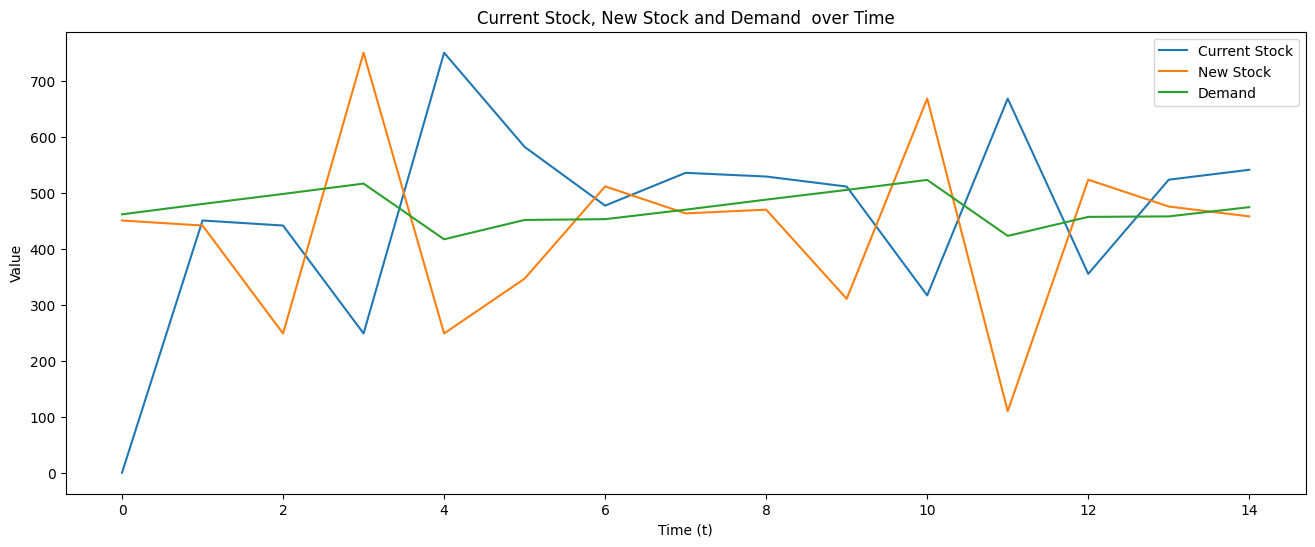

In [18]:

import matplotlib.pyplot as plt
df = pd.read_csv('details.csv')
plt.figure(figsize=(16,6))

plt.plot([i for i in range(len(current_stock_list))], current_stock_list, label='Current Stock')
plt.plot([i for i in range(len(new_stock_list))], new_stock_list, label='New Stock')
plt.plot([i for i in range(len(demand_list))], demand_list, label='Demand')

# Add labels and title
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Current Stock, New Stock and Demand  over Time')

# Add legend and show plot
plt.legend()
plt.show()


In [19]:
total_production_cost

32083.46852899826

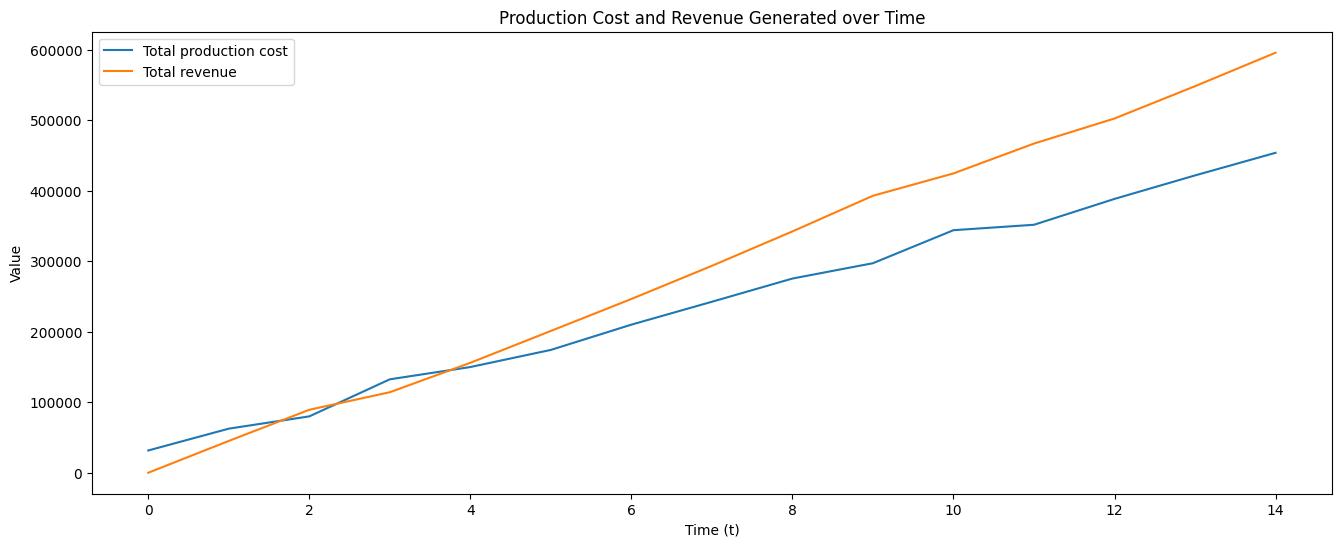

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot([i for i in range(len(np.cumsum(production_cost_list)))], np.cumsum(production_cost_list), label='Total production cost')
plt.plot([i for i in range(len(np.cumsum(revenue_list)))], np.cumsum(revenue_list), label='Total revenue')

plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Production Cost and Revenue Generated over Time')

# Add legend and show plot
plt.legend()
plt.show()


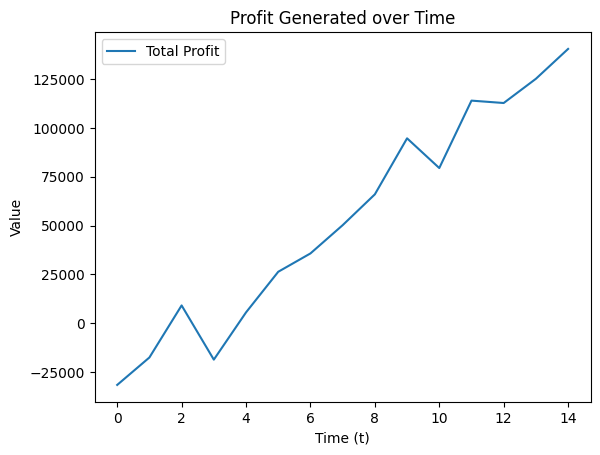

In [21]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(np.cumsum(profit_list)))], np.cumsum(profit_list), label='Total Profit')

plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Profit Generated over Time')

# Add legend and show plot
plt.legend()
plt.show()

In [22]:
# !zip -r /content/checkpoint.zip /root/ray_results/PPO_SimpleSupplyChain/PPO_SimpleSupplyChain_5896e_00000_0_lr=0.0010_2024-04-10_12-53-36

### visulization

In [35]:
result_df = best_result.metrics_dataframe
result_df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_agent_steps_sampled,...,config/input,config/policies/default_policy,config/callbacks,config/create_env_on_driver,config/custom_eval_function,config/framework,config/num_cpus_for_driver,config/num_workers,perf/cpu_util_percent,perf/ram_util_percent
0,3.952524e+06,3.732262e+06,3.824664e+06,364.0,10,0,0,0,0,4000,...,sampler,"[None, None, None, None]",<class 'ray.rllib.algorithms.callbacks.Default...,False,None,torch,1,0,14.931783,43.197674


<Axes: xlabel='training_iteration'>

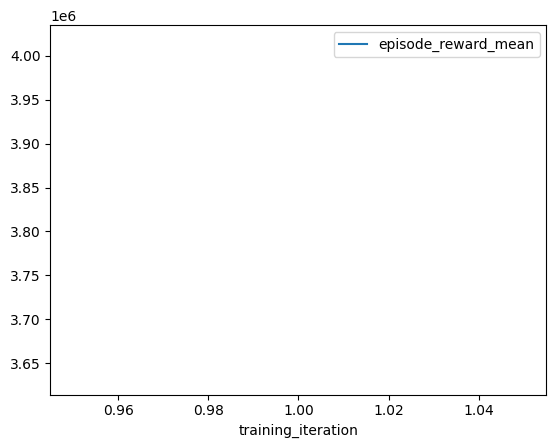

In [36]:
best_result.metrics_dataframe.plot("training_iteration", "episode_reward_mean")


In [37]:
# df = df[6:]

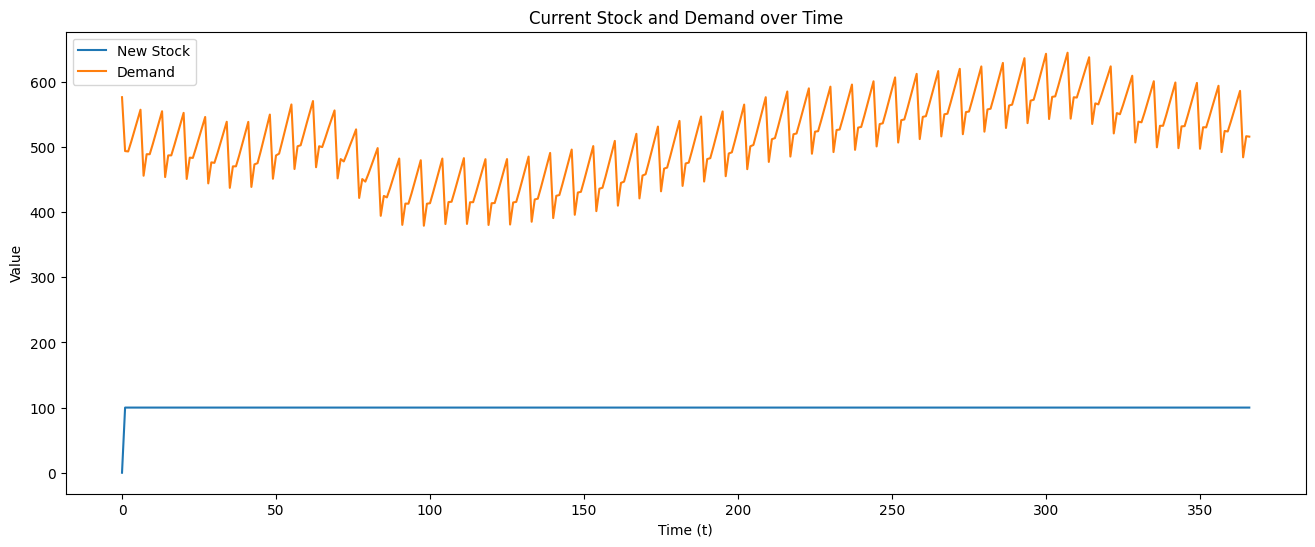

In [38]:

import matplotlib.pyplot as plt
df = pd.read_csv('details.csv')
plt.figure(figsize=(16,6))

plt.plot([i for i in range(len(df))], df['new_stock'], label='New Stock')
plt.plot([i for i in range(len(df))], df['demand'], label='Demand')

# Add labels and title
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Current Stock and Demand over Time')

# Add legend and show plot
plt.legend()
plt.show()


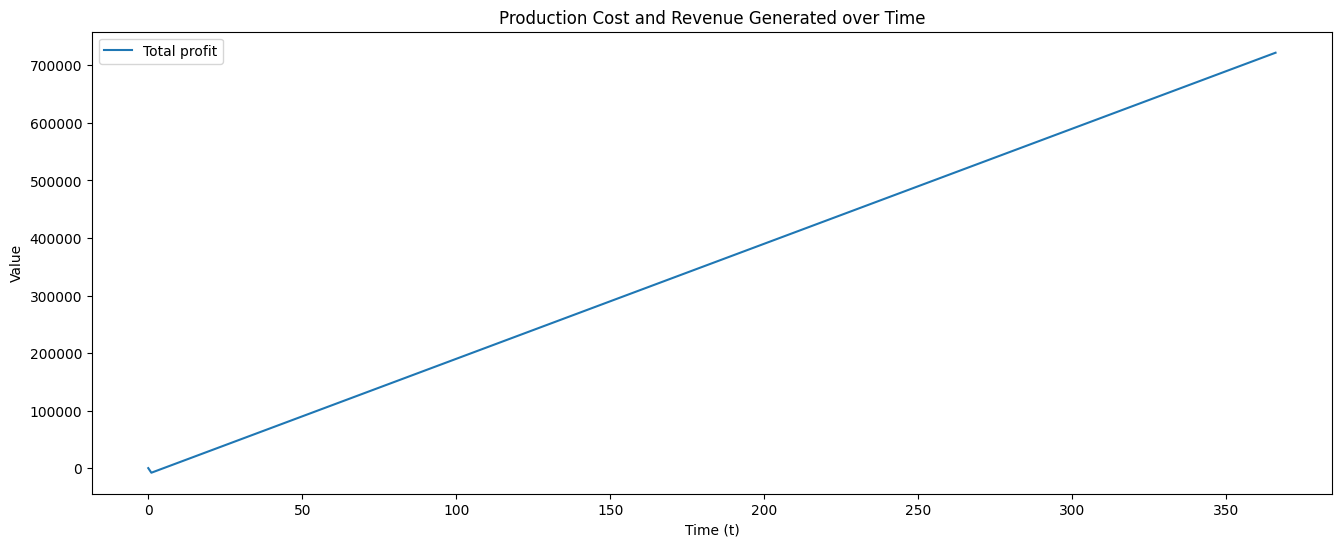

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))

plt.plot([i for i in range(len(np.cumsum(df['reward'])))], np.cumsum(df['reward']), label='Total profit')

plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Production Cost and Revenue Generated over Time')

# Add legend and show plot
plt.legend()
plt.show()


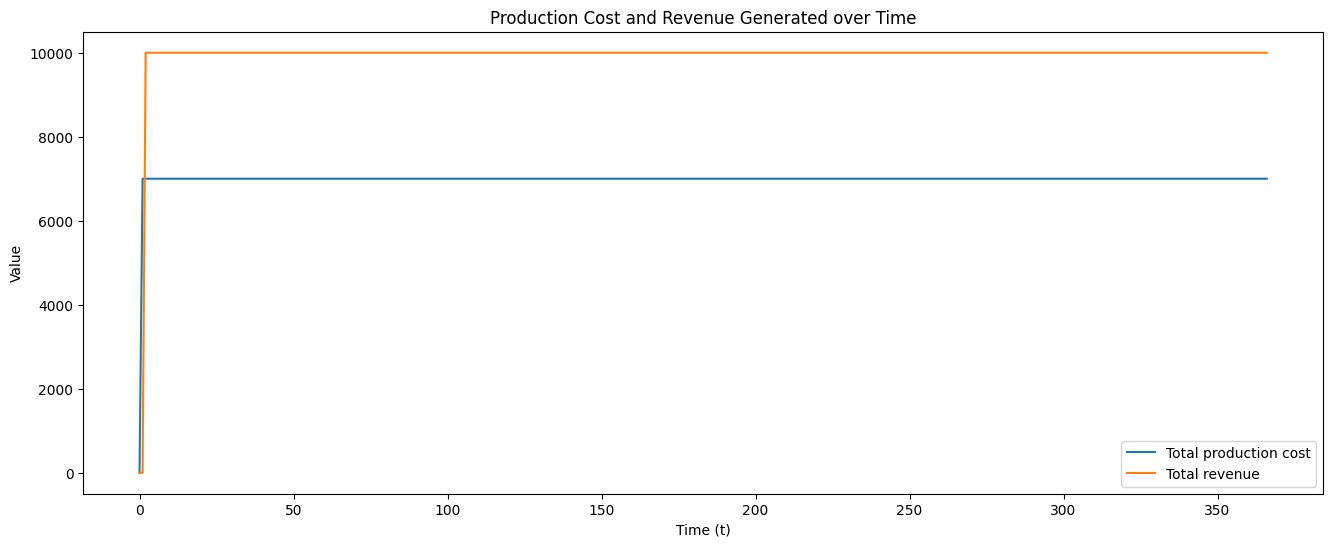

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot([i for i in range(len(df['total_production_cost']))], df['total_production_cost'], label='Total production cost')
plt.plot([i for i in range(len(df['total_revenue_generated']))], df['total_revenue_generated'], label='Total revenue')

plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Production Cost and Revenue Generated over Time')

# Add legend and show plot
plt.legend()
plt.show()


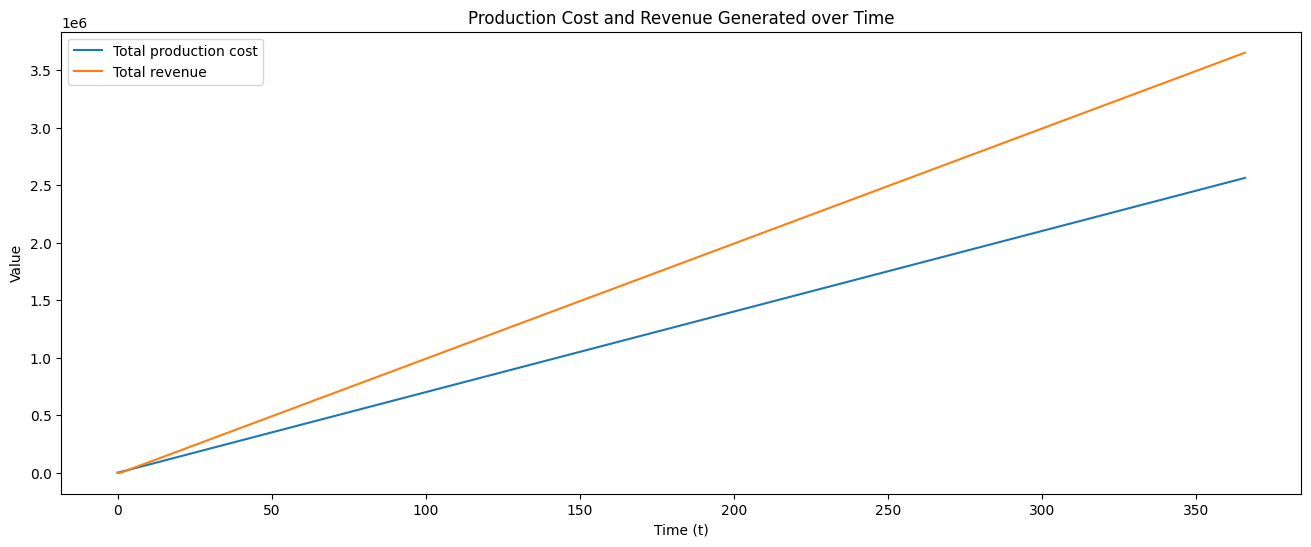

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot([i for i in range(len(np.cumsum(df['total_production_cost'])))], np.cumsum(df['total_production_cost']), label='Total production cost')
plt.plot([i for i in range(len(np.cumsum(df['total_revenue_generated'])))], np.cumsum(df['total_revenue_generated']), label='Total revenue')

plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Production Cost and Revenue Generated over Time')

# Add legend and show plot
plt.legend()
plt.show()
